### Import modules

In [85]:
import pandas as pd
import pandas_profiling as pdp
import matplotlib.pyplot as plt
import os
import numpy as np
import warnings

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import lightgbm as lgbm

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 30)

### Import data

In [34]:
inputdir = 'data'
train_df = pd.read_csv(os.path.join(inputdir, 'HR_info.csv'))

### Exploratory data analysis
Create pandas profiling

In [35]:
p_dir = 'profile'
if(not os.path.exists(p_dir)):
    os.mkdir(p_dir)

train_p = pdp.ProfileReport(train_df)
train_p.to_file( os.path.join(p_dir, 'train_df.html') )

In [36]:
train_df.head().T

,0,1,2,3,4
satisfaction_level,0.38,0.8,0.11,0.72,0.37
last_evaluation,0.53,0.86,0.88,0.87,0.52
number_project,2,5,7,5,2
average_montly_hours,157,262,272,223,159
time_spend_company,3,6,4,5,3
Work_accident,0,0,0,0,0
left,1,1,1,1,1
promotion_last_5years,0,0,0,0,0
department,sales,sales,sales,sales,sales
salary,low,medium,medium,low,low


In [63]:
train_df.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
department                object
salary                    object
dtype: object

In [75]:
out_df = pd.get_dummies(train_df, drop_first=True)
out_df.head().T

,0,1,2,3,4
satisfaction_level,0.38,0.80,0.11,0.72,0.37
last_evaluation,0.53,0.86,0.88,0.87,0.52
number_project,2.00,5.00,7.00,5.00,2.00
average_montly_hours,157.00,262.00,272.00,223.00,159.00
time_spend_company,3.00,6.00,4.00,5.00,3.00
Work_accident,0.00,0.00,0.00,0.00,0.00
left,1.00,1.00,1.00,1.00,1.00
promotion_last_5years,0.00,0.00,0.00,0.00,0.00
department_RandD,0.00,0.00,0.00,0.00,0.00
department_accounting,0.00,0.00,0.00,0.00,0.00


In [111]:
# 部署ごとの離職率を算出
num_sales_left = train_df.groupby(['department', 'left']).size() 

In [71]:
target_col = 'left'
y = out_df[target_col]
X = out_df.drop(target_col, axis=1)

### Run lightGBM

[1]	valid_0's multi_logloss: 0.526193
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's multi_logloss: 0.509885
[3]	valid_0's multi_logloss: 0.494616
[4]	valid_0's multi_logloss: 0.480268
[5]	valid_0's multi_logloss: 0.466753
[6]	valid_0's multi_logloss: 0.453971
[7]	valid_0's multi_logloss: 0.441858
[8]	valid_0's multi_logloss: 0.430347
[9]	valid_0's multi_logloss: 0.419382
[10]	valid_0's multi_logloss: 0.408936
[11]	valid_0's multi_logloss: 0.398948
[12]	valid_0's multi_logloss: 0.389354
[13]	valid_0's multi_logloss: 0.380242
[14]	valid_0's multi_logloss: 0.371509
[15]	valid_0's multi_logloss: 0.363096
[16]	valid_0's multi_logloss: 0.354995
[17]	valid_0's multi_logloss: 0.347244
[18]	valid_0's multi_logloss: 0.339741
[19]	valid_0's multi_logloss: 0.33253
[20]	valid_0's multi_logloss: 0.325578
[21]	valid_0's multi_logloss: 0.318875
[22]	valid_0's multi_logloss: 0.312391
[23]	valid_0's multi_logloss: 0.306126
[24]	valid_0's multi_logloss: 0.30008
[25]	valid_0'

<BarContainer object of 20 artists>

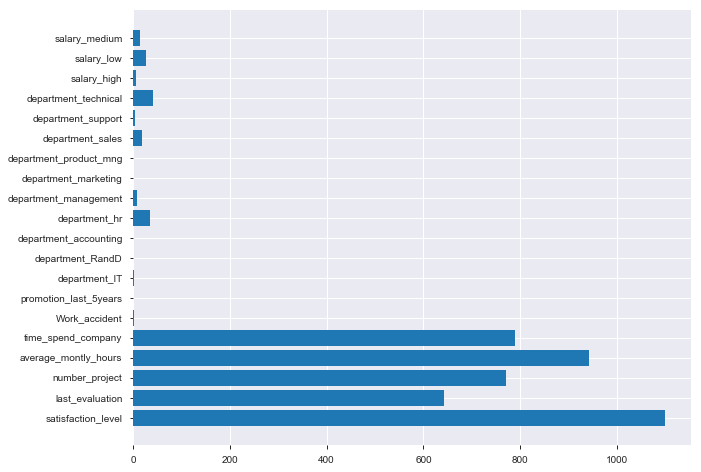

In [110]:
# Split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y)

lgbm_train = lgbm.Dataset(X_train, y_train)
lgbm_eval = lgbm.Dataset(X_test, y_test, reference=lgbm_train)

# Setting the training parameters
params = {'task': 'train',
          'boosting_type': 'gbdt',
          'objective': 'multiclass',
          'metric': {'multi_logloss'},
          'num_class': 3,
          'learning_rate': 0.02,
          'num_leaves': 23,
          'min_data_in_leaf': 1,
          'num_iteration': 100,
          'verbose': 0}

# Model training
mdl = lgbm.train(params,
                  lgbm_train,
                  num_boost_round=50,
                  valid_sets=lgbm_eval,
                  early_stopping_rounds=20)

# Estimate with test data
y_pred = mdl.predict(X_test, num_iteration=mdl.best_iteration)
y_pred_max = np.argmax(y_pred, axis=1)

# Calculate accuracy 
accuracy = sum(y_test == y_pred_max) / len(y_test)
print('accuracy:', accuracy)

# Show importance
importance = pd.DataFrame(mdl.feature_importance(), index=X.columns, columns=['importance'])
fig = plt.figure(figsize=(10,8))
plt.barh(importance.index, importance['importance'].values)

In [ ]:
satisfaction_level
average_monthly_hours
time_spend_company
number_project
last_evaluation